## Exercício: LoRA

* Foi utilizado o mesmo modelo do exercício anterior (GPT-2)
* O modelo foi treinado com 70% dos dados e foi congelado
* As matrizes A e B foram adicionadas em todas as camadas lineares e embeddings
* O modelo LoRA foi treinado com 20% dos dados e avaliado na mesma tarefa de prever a próxima palavra

## Resultados:

* Pré-treinamento: 7,3 min/época | Fine-tuning com LoRA: 3,7 min/época
* Acurácia, Loss e Perplexidade pioraram
* Na geração de texto não houveram mudanças perceptíveis

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Tokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

C:\Users\limalucas\AppData\Local\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [ ]:
#!git clone https://github.com/ethelbeluzzi/projetomachado

In [ ]:
import os

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# A príncipio, não estamos limpando as linhas
with open(DATA_PATH, "r", encoding="utf-8") as data_file:
    lines = [line for line in data_file]

# É possível voltar a um texto monolítico juntando as linhas.
full_data = ' '.join(lines)
#full_data = full_data[:100000] # Limitando para testes
full_data = tokenizer(full_data).input_ids[1:-1]
len(full_data)

4903405

In [ ]:
from sklearn.model_selection import train_test_split

# Primeiro, separa 30% para val/test e 70% para treino
train_text, temp_text = train_test_split(full_data, test_size=0.3, random_state=18, shuffle=False)

# Depois, separa os 30% restantes em 20% (train2) e 10% (validação)
train_lora_text, val_text = train_test_split(temp_text, test_size=1/3, random_state=18, shuffle=False)

# Verifica os tamanhos
len(train_text), len(train_lora_text), len(val_text)

(3432383, 980681, 490341)

## Classe do dataset

Utilize o Tokenizer do Bert na classe Dataset.
Defina um tamanho de sequencia/contexto.

In [ ]:
from torch.utils.data import Dataset

context_size = 9  # 7 palavras de entrada. O target é a próxima palavra. <sos> no começo e <eos> no final
"""TODO: Preparar o dataset"""
class TextDataset(Dataset):
    def __init__(self, text, context_size):
        self.pairs = self.create_context_target_pairs(text, context_size)

    def create_context_target_pairs(self, text, context_size):
        context_target_pairs = []

        # Gerar pares (contexto, target) ignorando targets desconhecidos
        for i in range(len(text) - context_size):
            context = text[i:i + context_size]
            target = text[i+1:i + context_size+1]

            context_target_pairs.append((context, target))

        return context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [ ]:
"""TODO: implemente a classe do dataset"""
train_data = TextDataset(train_text, context_size)
train_lora_data = TextDataset(train_lora_text, context_size)
val_data = TextDataset(val_text, context_size)
len(train_data), len(train_lora_data), len(val_data)

(3432374, 980672, 490332)

In [ ]:
# Exemplo de acesso a um item do dataset
for i in range(3):
  sample_context, sample_target = train_data[i]
  print(f"Contexto: {sample_context}, Target: {sample_target}")

Contexto: tensor([  205,   213,  7073,  6538, 22321, 22352, 21748, 22317,   250]), Target: tensor([  213,  7073,  6538, 22321, 22352, 21748, 22317,   250, 22301])
Contexto: tensor([  213,  7073,  6538, 22321, 22352, 21748, 22317,   250, 22301]), Target: tensor([ 7073,  6538, 22321, 22352, 21748, 22317,   250, 22301,   187])
Contexto: tensor([ 7073,  6538, 22321, 22352, 21748, 22317,   250, 22301,   187]), Target: tensor([ 6538, 22321, 22352, 21748, 22317,   250, 22301,   187, 18199])


## DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_lora_loader = DataLoader(train_lora_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
sample = next(iter(train_loader))

In [ ]:
context_batch, target_batch = sample

print(f"Dimensões do contexto no lote: {context_batch.shape}")
print(f"Dimensões do alvo no lote: {target_batch.shape}")
context_batch, target_batch

Dimensões do contexto no lote: torch.Size([512, 9])
Dimensões do alvo no lote: torch.Size([512, 9])


(tensor([[18626,  1780,   117,  ...,   125,  5995,   252],
         [22278,   670,   698,  ...,  8925,  4014,   180],
         [  117, 18691,  4640,  ...,  1076,   879, 19927],
         ...,
         [ 8774,   117,  2514,  ...,  8156, 22280,   122],
         [  180,  7308,  2536,  ...,   131,   520,   421],
         [  123,  1851,  1382,  ..., 11631,  4924,   122]]),
 tensor([[ 1780,   117,   170,  ...,  5995,   252,   132],
         [  670,   698, 22281,  ...,  4014,   180, 10219],
         [18691,  4640,   117,  ...,   879, 19927, 22290],
         ...,
         [  117,  2514,   125,  ..., 22280,   122,  3836],
         [ 7308,  2536,   240,  ...,   520,   421,   146],
         [ 1851,  1382,   182,  ...,  4924,   122,  4010]]))

## Modelo

In [ ]:
class Head(nn.Module):
    """ uma cabeça de auto-atenção """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # Máscara causal

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape  # batch, seq_len, emb_size
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # Calcular scores de atenção
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # Agregação ponderada dos valores
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """ múltiplas cabeças de auto-atenção em paralelo """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # Concatena as saídas de todas as cabeças
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ uma camada linear simples seguida por uma não-linearidade """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Bloco Transformer: comunicação seguida de computação """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Microtransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # normalização final
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T, C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)  # (B, T, C)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        return logits

In [ ]:
# hyperparameters
vocab_size = 29794
block_size = 9
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.3

In [ ]:
model = Microtransformer()
model

Microtransformer(
  (token_embedding_table): Embedding(29794, 128)
  (position_embedding_table): Embedding(9, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.3, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.3, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=T

In [ ]:
#!pip install torchinfo -q

In [ ]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Microtransformer                              --
├─Embedding: 1-1                              3,813,632
├─Embedding: 1-2                              1,152
├─Sequential: 1-3                             --
│    └─Block: 2-1                             --
│    │    └─MultiHeadAttention: 3-1           65,664
│    │    └─FeedFoward: 3-2                   131,712
│    │    └─LayerNorm: 3-3                    256
│    │    └─LayerNorm: 3-4                    256
│    └─Block: 2-2                             --
│    │    └─MultiHeadAttention: 3-5           65,664
│    │    └─FeedFoward: 3-6                   131,712
│    │    └─LayerNorm: 3-7                    256
│    │    └─LayerNorm: 3-8                    256
│    └─Block: 2-3                             --
│    │    └─MultiHeadAttention: 3-9           65,664
│    │    └─FeedFoward: 3-10                  131,712
│    │    └─LayerNorm: 3-11                   256
│    │    └─LayerNorm:

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=100) #"""TODO CrossEntropy""""
def calculate_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_words = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            # Forward pass
            outputs = model(contexts)

            # Ajustar as dimensões
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
            targets = targets.view(-1)  # (batch_size * seq_len)
            # Calculate the loss
            loss = criterion(outputs, targets)

            # Accumulate the loss and the number of words
            total_loss += loss.item() #* contexts.size(0)
            #total_words += targets.size(0)

    # Compute the average loss
    avg_loss = total_loss / len(dataloader)

    # Calculate the perplexity
    perplexity = np.exp(avg_loss)

    return perplexity

In [ ]:
train_perplexity = calculate_perplexity(model, train_loader, criterion, device)
print(f"Perplexidade no conjunto de treino: {train_perplexity:.2f}")

Perplexidade no conjunto de treino: 35866.73


Epoch 1/10 - Train Loss: 5.8201 - Val Loss: 5.2840 - Train Accuracy: 0.1321 - Val Accuracy: 0.1645 - Time: 7.33 min
Epoch 2/10 - Train Loss: 4.9036 - Val Loss: 5.0373 - Train Accuracy: 0.1843 - Val Accuracy: 0.1857 - Time: 7.35 min
Epoch 3/10 - Train Loss: 4.6703 - Val Loss: 4.9390 - Train Accuracy: 0.1997 - Val Accuracy: 0.1967 - Time: 7.33 min
Epoch 4/10 - Train Loss: 4.5388 - Val Loss: 4.8889 - Train Accuracy: 0.2088 - Val Accuracy: 0.2029 - Time: 7.36 min
Epoch 5/10 - Train Loss: 4.4497 - Val Loss: 4.8563 - Train Accuracy: 0.2151 - Val Accuracy: 0.2071 - Time: 7.33 min
Epoch 6/10 - Train Loss: 4.3840 - Val Loss: 4.8426 - Train Accuracy: 0.2200 - Val Accuracy: 0.2097 - Time: 7.34 min
Epoch 7/10 - Train Loss: 4.3321 - Val Loss: 4.8281 - Train Accuracy: 0.2239 - Val Accuracy: 0.2124 - Time: 7.33 min
Epoch 8/10 - Train Loss: 4.2899 - Val Loss: 4.8195 - Train Accuracy: 0.2273 - Val Accuracy: 0.2140 - Time: 7.35 min
Epoch 9/10 - Train Loss: 4.2542 - Val Loss: 4.8122 - Train Accuracy: 0.2

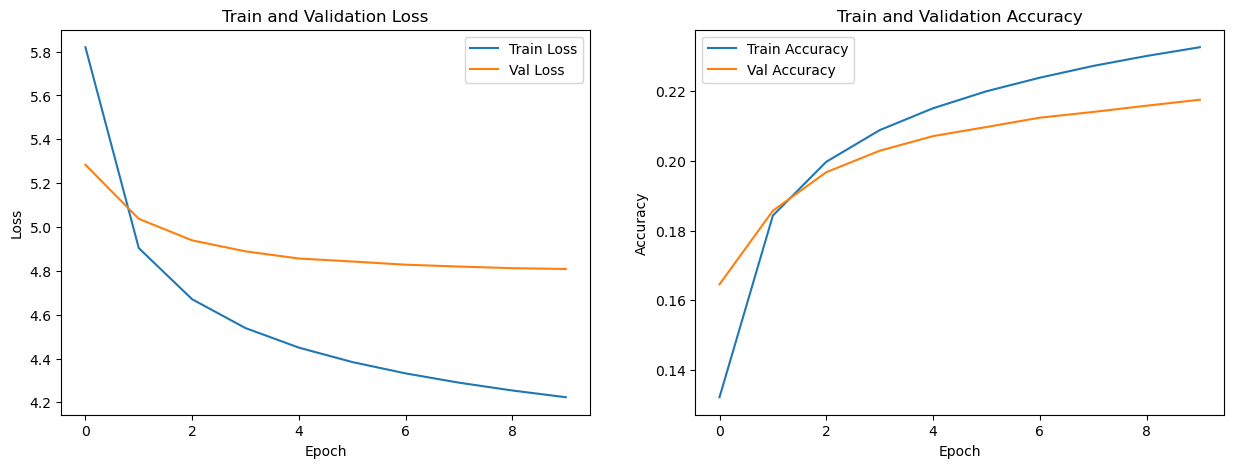

In [ ]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 10
lr = 1e-4  # Taxa de aprendizado
criterion = nn.CrossEntropyLoss(ignore_index=100)  # Função de perda CrossEntropy

optimizer = optim.AdamW(model.parameters(), lr=lr)  # Otimizador AdamW

model.to(device)

# Função de Treinamento
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for contexts, targets in dataloader:
        contexts, targets = contexts.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(contexts)

        # Ajustar as dimensões
        outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
        targets = targets.view(-1)  # (batch_size * seq_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * contexts.size(0)

        # Cálculo da acurácia
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Função de Avaliação
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            outputs = model(contexts)

            # Ajustar as dimensões
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
            targets = targets.view(-1)  # (batch_size * seq_len)

            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * contexts.size(0)

            # Cálculo da acurácia
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Loop de Treinamento e Avaliação com Tempo por Época
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device, print_epoch = True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        start_time = time.time()  # Captura o tempo inicial da época

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        end_time = time.time()  # Captura o tempo final da época
        epoch_time = (end_time - start_time) / 60  # Tempo da época em minutos

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if print_epoch == True:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
                  f"Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f} - "
                  f"Time: {epoch_time:.2f} min")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Treinamento e Avaliação
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)

# Plotar Gráficos de Loss e Acurácia
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Loss
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train and Validation Loss')
    axs[0].legend()

    # Plot de Acurácia
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train and Validation Accuracy')
    axs[1].legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
""" TODO: calcule a perplexidade final no dataset de validação """
val_perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {val_perplexity:.2f}")

Perplexidade no conjunto de validação: 122.54


## Geração sem temperatura

In [ ]:
# Função para gerar texto a partir de um modelo
def generate_text(model, context, max_length, context_size, device):
    model.eval()

    generated_indices = []
    context = context
    # Começar a geração de texto
    for i in range(max_length):
        # Obter o contexto atual
        input_context = torch.tensor(context[-context_size:], dtype=torch.long, device=device).unsqueeze(0)
        # Forward pass
        with torch.no_grad():
            output = model(input_context) # output.shape: (1, seq_len, vocab_size)

        # Obter o índice da palavra mais provável para o próximo token
        next_token_logits = output[:, -1, :]  # (1, vocab_size)
        predicted_index = torch.argmax(next_token_logits, dim=-1).item()

        # Adicionar o índice ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    # Decodificar os índices gerados para texto usando o tokenizer do BERT
    generated_text = tokenizer.decode(generated_indices)#, skip_special_tokens=True)

    return tokenizer.decode(context[:context_size]) + ' ' + generated_text

# Função para pegar um contexto aleatório do val_data
def get_random_context(val_text, context_size):
    # Escolha um índice aleatório para começar
    start_index = random.randint(0, len(val_text) - context_size)
    context = val_text[start_index:start_index + context_size]

    return context

# Exemplo de uso
context_size = 9
for i in range(5):
  context = get_random_context(val_text, context_size)
  context_text = tokenizer.decode(context)
  print("Contexto Inicial:", context_text)

  max_length = 150
  generated_text = generate_text(model, context, max_length, context_size, device)
  print(f"Texto gerado: {generated_text}")
  print("-" * 100 )

Contexto Inicial: ; ela, porém, vendo que eu estava
Texto gerado: .. Não é preciso dizer que o senhor no céu. Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor
----------------------------------------------------------------------------------------------------
Contexto Inicial: ; e daí vem a dificuldade de cantar coisas
Texto gerado: que o senhor me disse que não.. , e não se pode ser que não... Não é preciso dizer que o senhor me disse que não... Não é preciso dizer que o senhor me

## Geração com temperatura

In [ ]:
import torch.nn.functional as F

# Função para gerar texto a partir de um modelo com temperatura
def generate_text_t(model, context, max_length, context_size, device, temperature=1.0):
    model.eval()

    generated_indices = []
    context = context

    # Começar a geração de texto
    for i in range(max_length):
        # Obter o contexto atual
        input_context = torch.tensor(context[-context_size:], dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        with torch.no_grad():
            output = model(input_context)  # output.shape: (1, seq_len, vocab_size)

        # Aplicar a temperatura
        next_token_logits = output[:, -1, :] / temperature  # Ajustar logits pela temperatura
        probabilities = F.softmax(next_token_logits, dim=-1)  # Converter logits em probabilidades

        # Amostrar o próximo token a partir das probabilidades ajustadas
        predicted_index = torch.multinomial(probabilities, num_samples=1).item()

        # Adicionar o índice ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    # Decodificar os índices gerados para texto usando o tokenizer do BERT
    generated_text = tokenizer.decode(generated_indices)

    return tokenizer.decode(context[:context_size]) + ' ' + generated_text

# Função para pegar um contexto aleatório do val_data
def get_random_context(val_text, context_size):
    # Escolha um índice aleatório para começar
    start_index = random.randint(0, len(val_text) - context_size)
    context = val_text[start_index:start_index + context_size]

    return context

# Exemplo de uso
context_size = 9
for i in range(5):
    context = get_random_context(val_text, context_size)
    context_text = tokenizer.decode(context)
    print("Contexto Inicial:", context_text)

    max_length = 100
    temperature = 0.7 # Ajuste a temperatura conforme necessário
    generated_text = generate_text_t(model, context, max_length, context_size, device, temperature=temperature)
    print(f"Texto gerado: {generated_text}")
    print("-" * 100)


Contexto Inicial: ama as musas a não falar de um
Texto gerado: . Eram quatro horas a pouco, e não amigo. A idéia da reconciliação. O que era, no quarto de hora, e julgava a casa do pai no espelho, com a sua lata, e foi pôlo a um sacrifício, tão nublado e triste. As próprias palavras, que não queriam bem, não é o próprio espírito. Não. Em vão, não menos de uma coisa. Explicava com a minha boca. Um dia, um e outro dia... Eram quatro horas a pouco, e não
----------------------------------------------------------------------------------------------------
Contexto Inicial: seus juízos? Em matéria de arte eu
Texto gerado: carta. A razão é que a vi, , como pela mulher, que não ia lá, e às vezes por si mesma, sem saber alguma coisa, e que a dança me levou a boa senhora, que este último regeio. E que não, muito bem, que é a coisa mais demora de uma pessoa que não o vi o que se achava na véspera. O Sr. Antunes não tinha vocação. Dez minutos depois, aliás, concluiu ele.... Gostei uma carta. A raz

# Adicionando LoRA

In [ ]:
class LoRALayer(nn.Module):
    """
    Cria as matrizes A e B para o modelo LoRA.
    Args:
        in_dim: dimensão de entrada
        out_dim: dimensão de saída
        rank: rank do modelo LoRA
        alpha: fator de escala para o modelo LoRA
    """
    def __init__(self, in_dim, out_dim, rank, alpha=1):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        return self.alpha * (x @ self.A @ self.B)

class EmbeddingWithLoRA(nn.Module):
    """
    Substitui a camada de embedding por uma versão com LoRA.
    Args:
        embed: camada de embedding original
        rank: rank do LoRA
        alpha: fator de escalonamento do LoRA
    """
    def __init__(self, embed, rank, alpha=1):
        super().__init__()
        self.embedding = embed
        self.lora = LoRALayer(embed.embedding_dim, embed.embedding_dim, rank, alpha)

    def forward(self, x):
        # Obtém a saída da camada de embedding original
        embed = self.embedding(x)
        # Aplica a transformação LoRA
        lora_output = self.lora(embed)
        # Retorna a soma da saída original com o ajuste LoRA
        return embed + lora_output

class LinearWithLoRA(nn.Module):
    """
    Combina a camada linear com a camada LoRA.
    Args:
        linear: camada linear original
        rank: rank do modelo LoRA
        alpha: fator de escala para o modelo LoRA
    """
    def __init__(self, linear, rank, alpha=1):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x):
        return self.linear(x) + self.lora(x)

class HeadWithLoRA(nn.Module):
    """ Uma cabeça de auto-atenção com LoRA """
    def __init__(self, head_size, rank, alpha):
        super().__init__()
        self.key = LinearWithLoRA(nn.Linear(n_embd, head_size, bias=False), rank, alpha)
        self.query = LinearWithLoRA(nn.Linear(n_embd, head_size, bias=False), rank, alpha)
        self.value = LinearWithLoRA(nn.Linear(n_embd, head_size, bias=False), rank, alpha)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v  # (B, T, head_size)
        return out

class MultiHeadAttentionWithLoRA(nn.Module):
    """ Múltiplas cabeças de auto-atenção com LoRA em paralelo """
    def __init__(self, num_heads, head_size, rank, alpha):
        super().__init__()
        self.heads = nn.ModuleList([HeadWithLoRA(head_size, rank, alpha) for _ in range(num_heads)])
        self.proj = LinearWithLoRA(nn.Linear(n_embd, n_embd), rank, alpha)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForwardWithLoRA(nn.Module):
    """Feed-forward com LoRA aplicado"""
    def __init__(self, feed_forward, rank, alpha):
        super().__init__()
        self.net = nn.Sequential(
            LinearWithLoRA(feed_forward.net[0], rank=rank, alpha=alpha),
            feed_forward.net[1],  # ReLU
            LinearWithLoRA(feed_forward.net[2], rank=rank, alpha=alpha),
            feed_forward.net[3]   # Dropout
        )

    def forward(self, x):
        return self.net(x)

class BlockWithLoRA(nn.Module):
    """ Bloco Transformer com LoRA: comunicação seguida de computação """
    def __init__(self, n_embd, n_head, rank, alpha):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttentionWithLoRA(n_head, head_size, rank, alpha)
        self.ffwd = FeedFowardWithLoRA(n_embd, rank, alpha)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class MicrotransformerWithLoRA(nn.Module):
    def __init__(self, rank, alpha):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[BlockWithLoRA(n_embd, n_head, rank, alpha) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = LinearWithLoRA(nn.Linear(n_embd, vocab_size), rank, alpha)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits


In [ ]:
import copy

# Definição dos hiperparâmetros do LoRA
lora_rank = 64
lora_alpha = 128

# Criação de uma cópia profunda do modelo para aplicar LoRA
model_lora = copy.deepcopy(model)

# Congelar todos os parâmetros do modelo
for param in model_lora.parameters():
    param.requires_grad = False

# Aplicar LoRA nas camadas de embedding
model_lora.token_embedding_table = EmbeddingWithLoRA(model_lora.token_embedding_table, rank=lora_rank, alpha=lora_alpha)
model_lora.position_embedding_table = EmbeddingWithLoRA(model_lora.position_embedding_table, rank=lora_rank, alpha=lora_alpha)



# Aplicar LoRA às camadas de atenção e feed-forward
for block in model_lora.blocks:
    # Aplicar LoRA nas cabeças de atenção
    for i, head in enumerate(block.sa.heads):
        block.sa.heads[i].key = LinearWithLoRA(head.key, rank=lora_rank, alpha=lora_alpha)
        block.sa.heads[i].query = LinearWithLoRA(head.query, rank=lora_rank, alpha=lora_alpha)
        block.sa.heads[i].value = LinearWithLoRA(head.value, rank=lora_rank, alpha=lora_alpha)

    # Substituir a camada de projeção final das atenções
    block.sa.proj = LinearWithLoRA(block.sa.proj, rank=lora_rank, alpha=lora_alpha)

    # Substituir a camada feed-forward com LoRA
    block.ffwd = FeedForwardWithLoRA(block.ffwd, rank=lora_rank, alpha=lora_alpha)

# Substituir as camadas finais do modelo
model_lora.lm_head = LinearWithLoRA(model_lora.lm_head, rank=lora_rank, alpha=lora_alpha)

# Inspecionar a estrutura do modelo com LoRA aplicado
print(model_lora)


Microtransformer(
  (token_embedding_table): EmbeddingWithLoRA(
    (embedding): Embedding(29794, 128)
    (lora): LoRALayer()
  )
  (position_embedding_table): EmbeddingWithLoRA(
    (embedding): Embedding(9, 128)
    (lora): LoRALayer()
  )
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): LinearWithLoRA(
              (linear): Linear(in_features=128, out_features=32, bias=False)
              (lora): LoRALayer()
            )
            (query): LinearWithLoRA(
              (linear): Linear(in_features=128, out_features=32, bias=False)
              (lora): LoRALayer()
            )
            (value): LinearWithLoRA(
              (linear): Linear(in_features=128, out_features=32, bias=False)
              (lora): LoRALayer()
            )
            (dropout): Dropout(p=0.3, inplace=False)
          )
        )
        (proj): LinearWithLoRA(
          (linear): Linear(in_features

In [ ]:
torchinfo.summary(model_lora)

Layer (type:depth-idx)                                  Param #
Microtransformer                                        --
├─EmbeddingWithLoRA: 1-1                                --
│    └─Embedding: 2-1                                   (3,813,632)
│    └─LoRALayer: 2-2                                   16,384
├─EmbeddingWithLoRA: 1-2                                --
│    └─Embedding: 2-3                                   (1,152)
│    └─LoRALayer: 2-4                                   16,384
├─Sequential: 1-3                                       --
│    └─Block: 2-5                                       --
│    │    └─MultiHeadAttention: 3-1                     204,928
│    │    └─FeedForwardWithLoRA: 3-2                    213,632
│    │    └─LayerNorm: 3-3                              (256)
│    │    └─LayerNorm: 3-4                              (256)
│    └─Block: 2-6                                       --
│    │    └─MultiHeadAttention: 3-5                     204,928
│    │  

Epoch 1/100 - Train Loss: 4.9215 - Val Loss: 5.4854 - Train Accuracy: 0.1749 - Val Accuracy: 0.1686 - Time: 3.67 min
Epoch 2/100 - Train Loss: 4.4247 - Val Loss: 5.5017 - Train Accuracy: 0.2067 - Val Accuracy: 0.1754 - Time: 3.67 min
Epoch 3/100 - Train Loss: 4.3090 - Val Loss: 5.5005 - Train Accuracy: 0.2164 - Val Accuracy: 0.1773 - Time: 3.67 min
Epoch 4/100 - Train Loss: 4.2364 - Val Loss: 5.5240 - Train Accuracy: 0.2226 - Val Accuracy: 0.1806 - Time: 3.69 min
Epoch 5/100 - Train Loss: 4.1828 - Val Loss: 5.5322 - Train Accuracy: 0.2275 - Val Accuracy: 0.1825 - Time: 3.73 min
Epoch 6/100 - Train Loss: 4.1404 - Val Loss: 5.5630 - Train Accuracy: 0.2317 - Val Accuracy: 0.1837 - Time: 3.70 min
Epoch 7/100 - Train Loss: 4.1059 - Val Loss: 5.5738 - Train Accuracy: 0.2350 - Val Accuracy: 0.1828 - Time: 3.68 min
Epoch 8/100 - Train Loss: 4.0773 - Val Loss: 5.5995 - Train Accuracy: 0.2375 - Val Accuracy: 0.1865 - Time: 3.70 min
Epoch 9/100 - Train Loss: 4.0538 - Val Loss: 5.6093 - Train Accu

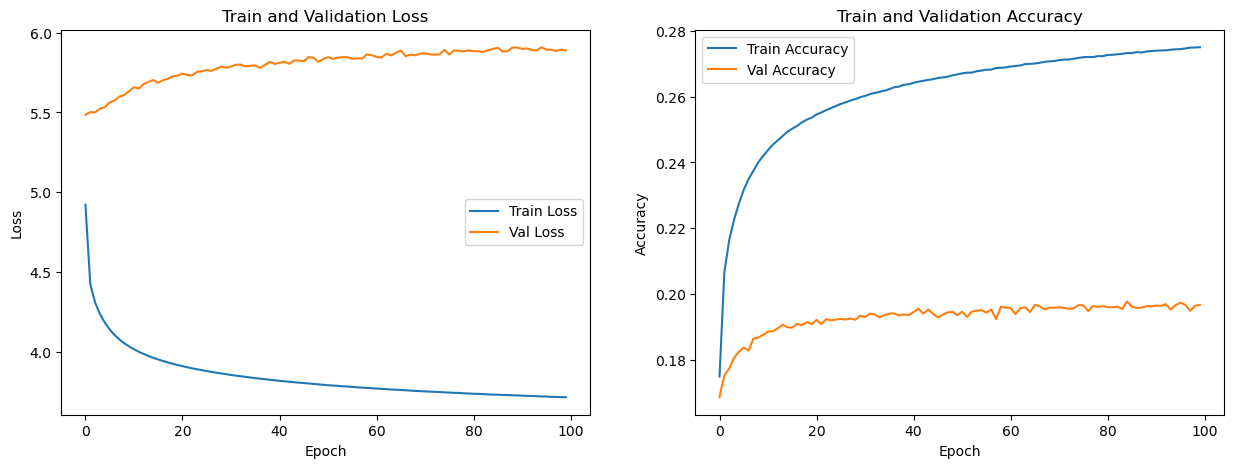

In [ ]:
epochs = 100
lr = 1e-4  # Taxa de aprendizado
criterion = nn.CrossEntropyLoss(ignore_index=100)  # Função de perda CrossEntropy

optimizer = optim.AdamW(model_lora.parameters(), lr=lr)  # Otimizador AdamW

model_lora.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
    model_lora, train_lora_loader, val_loader, optimizer, criterion, epochs, device
)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Geração sem temperatura

In [ ]:
# Exemplo de uso
context_size = 9
for i in range(5):
  context = get_random_context(val_text, context_size)
  context_text = tokenizer.decode(context)
  print("Contexto Inicial:", context_text)

  max_length = 150
  generated_text = generate_text(model_lora, context, max_length, context_size, device)
  print(f"Texto gerado: {generated_text}")
  print("-" * 100 )

Contexto Inicial: . A atitude não o satisfazia de todo
Texto gerado: não é que o senhor é que não é , e o que lhe dissesse. Não, não, não, mas, por que não seja alterado, e que o nosso Rubião não desistiu da casa, e o homem, que era um homem que não lhe pareceu que o senhor não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é que o senhor é que não é
----------------------------------------------------------------------------------------------------
Contexto Inicial: Pois que me fecham a porta dos
Texto gerado: é que não é que o senhor é que armarinhos, e o que lhe dissesse. Não, não, não, mas, por que não seja alterado, e que o nosso Rubião não desistiu da casa, e o homem, que era um homem que não lhe pareceu qu

# Geração com temperatura

In [ ]:
# Exemplo de uso
context_size = 9
for i in range(5):
    context = get_random_context(val_text, context_size)
    context_text = tokenizer.decode(context)
    print("Contexto Inicial:", context_text)

    max_length = 100
    temperature = 0.7 # Ajuste a temperatura conforme necessário
    generated_text = generate_text_t(model, context, max_length, context_size, device, temperature=temperature)
    print(f"Texto gerado: {generated_text}")
    print("-" * 100)

Contexto Inicial: ##lo? Não posso aturála. Virgem
Texto gerado: ......... Nossa Senhora! CAPÍTULO XII A ESQUERDA BARÃO Fico. Não tinha a mesma coisa. Não é? perguntou a moça. Eu................................................................
----------------------------------------------------------------------------------------------------
Contexto Inicial: se não for menos ; estou desenganado
Texto gerado: ##atibilidade de um instante, uma vez , porém, não acabava de acender o que é que durante alguns dias a noite talvez de hoje, que lá estava assim. Já vês? Você não o achou que eu só lhe haviam de ir, e a mãe lhe dão. Jorge não conhecia esses defeitos e zelos. Na manhã seguinte estavam na sala de visitas, e o pai, e que o Sr. Soares acabou, não tendo de todo o tempo de deixar a frase incompatibilidade de um instante, uma vez
----------------------------------------------------------------------------------------------------
Contexto Inicial: ##ândega ; alegres, mas hon
Texto gerado:

In [ ]:
""" TODO: calcule a perplexidade final no dataset de validação """
val_perplexity = calculate_perplexity(model_lora, val_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {val_perplexity:.2f}")

Perplexidade no conjunto de validação: 360.81
